## Stokes Flow in Periodic Channel with Robin boundary.

In [1]:
import sys
sys.path.append('/home/emastr/phd/')

import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from stokes2d.navier_stokes_robin import testSolve, testSolve2, solveRobinStokes_fromFunc
from util.plot_tools import *
from boundary_solvers.geometry import MacroGeom
import torch

## Robin Problem, Example:

The purpose of this framework is to solve the forced stokes flow equations

\begin{equation}
\Delta u  - \nabla p = f, \qquad \qquad \nabla \cdot u = 0
\end{equation}

with the boundary conditions

\begin{equation}
u(x, -1) + \alpha(x)\partial_y u(x, -1) = 0,\qquad \qquad u(x, 1) = g(x).
\end{equation}

We represent the solution by means of a stream function $\Psi(x,y) = \sin(2\pi m x)\cos(2\pi n y)$. Using this we obtain

\begin{equation}
    u(x,y) = \partial_y \Psi(x,y) = -2\pi n\sin(2\pi m x)\sin(2\pi n y), \qquad v(x,y) = -\partial_x\Psi(x,y) = -2\pi m\cos(2\pi m x)\cos(2\pi n y)
\end{equation}


In [ ]:
plt.figure()

def callback(it, u, v, *args):
    if it == 0:
        x,y = u.grid()
        meta = {"x": x, "y": y}
        torch.save(meta, f"/home/emastr/phd/data/navier_stokes/meta.dict")
        
    print(f"iter {it}: {u.eval_grid().max()}", end='\r')
    ug = u.eval_grid()
    vg = v.eval_grid()
    w = u.diff(0,1) - v.diff(1,0)
    
    plt.figure(1)
    if it % 2 == 0:
        plt.loglog(np.abs(w.basis.coef[:,0]))
        plt.ylim([1e-15, 1e2])
    
    data = {"n": it, "u": ug, "v": vg}
    torch.save(data, f"/home/emastr/phd/data/navier_stokes/frame_{it}.dict")
    
#testSolve(51,73, 201, T=1, callback=callback)
testSolve2(51,73, 301, T=2, with_gmres=False, callback=callback)


## Multiscale Problem

We define a multiscale problem as follows. The PDE is a non-slip zero forcing Stokes flow Problem

\begin{equation}
\Delta u  - \nabla p = 0, \qquad \qquad \nabla \cdot u = 0   \qquad \text{inside}\quad \Omega
\end{equation}

with the boundary conditions

\begin{equation}
u = g,\qquad \text{on}\quad\partial\Omega
\end{equation}

the boundary is a two-dimensional pipe with corners at (0,-1) and (1,1), and a micro scale boundary:

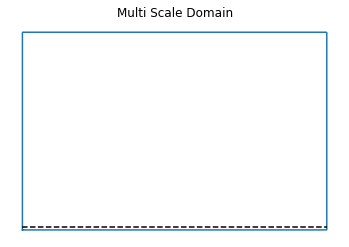

In [3]:
from hmm.stokes import StokesMacProb, StokesMicProb, trig_interp, StokesData, StokesHMMProblem
from hmm.stokes import MacroSolver, MicroSolver, IterativeHMMSolver
from util.plot_tools import *

eps = 0.02
k = round(1 / eps / 4) * 4

A = 0.
h = 1.5
f = lambda x: eps * (-h + A * np.cos(k*x)) #1.6
df = lambda x: -eps * k * np.sin(k*x) * A
ddf = lambda x: -eps * (k**2) * np.cos(k*x) * A
g = lambda x: 1+np.sin(2*np.pi * x) * 0.5
data = StokesData(f, df, ddf, g)

plt.figure()
plt.title("Multi Scale Domain")
data.plot(plt.gca())
remove_axes(plt.gca())


## Coupling to Micro Domain

To couple the macro domain to the microscopic domain, we make use of the HMM framework.
We construct a set of evenly spaced micro problems based on the Stokes data. The macro problem is constructed with a pre-specified resolution in the x- and y-directions.

(-1.02, -0.88)

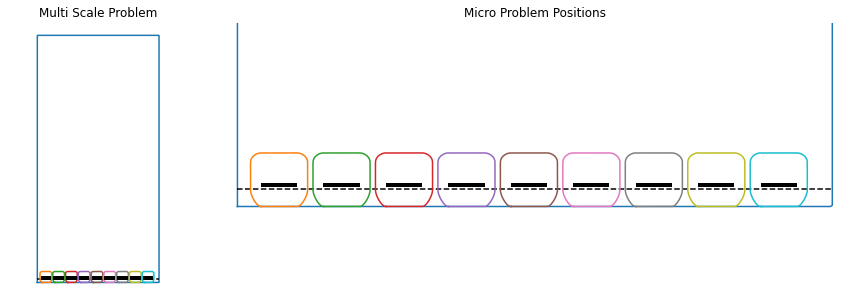

In [23]:
# Macro problem
xDim = 21
yDim = 23
iDeg = 13 #nMic*2 +1
macro = StokesMacProb(data, lambda x,a: trig_interp(x,a, iDeg))

# Micro problems
nMic = 9
xPos = np.linspace(4*eps, 1-4*eps, nMic)-2*eps
micros = [StokesMicProb(data, x, 3*eps, 3*eps, 0.1) for x in xPos]

# Hmm problem.
hmm_prob = StokesHMMProblem(macro, micros, data)

## PLOT ##

plt.figure(figsize=(15,5))

plt.subplot2grid((1,4), (0,0), colspan=1)
plt.title("Multi Scale Problem")
hmm_prob.plot(plt.gca())
plt.axis("Equal")
remove_axes(plt.gca())

plt.subplot2grid((1,4), (0,1), colspan=3)
plt.title("Micro Problem Positions")
hmm_prob.plot(plt.gca())
plt.axis("Equal")
remove_axes(plt.gca())
plt.xlim([-eps,1 + eps])
plt.ylim([-1-1*eps, -1+6*eps])

## Solving using HMM iterations

To solve the problem, we make use of a sequence of micro solvers, as well as a micro solver.

In [26]:
def debug_cb(it, macro_sol, micro_sols):
    pass

print("Precomputing...")
macro_solver = MacroSolver(xDim, yDim)
micro_solvers = [MicroSolver(m) for m in micros]
hmm_solver = IterativeHMMSolver(macro_solver, micro_solvers)
print("Done")


print("HMM Solver...")
macro_guess = macro_solver.solve(macro)
(macro_sol, micro_sols) = hmm_solver.solve(hmm_prob, macro_guess=macro_guess, 
                                           callback=debug_cb, verbose=True, maxiter=7)
print("\nDone")

Precomputing...
Done
HMM Solver...
Step 6/7
Done


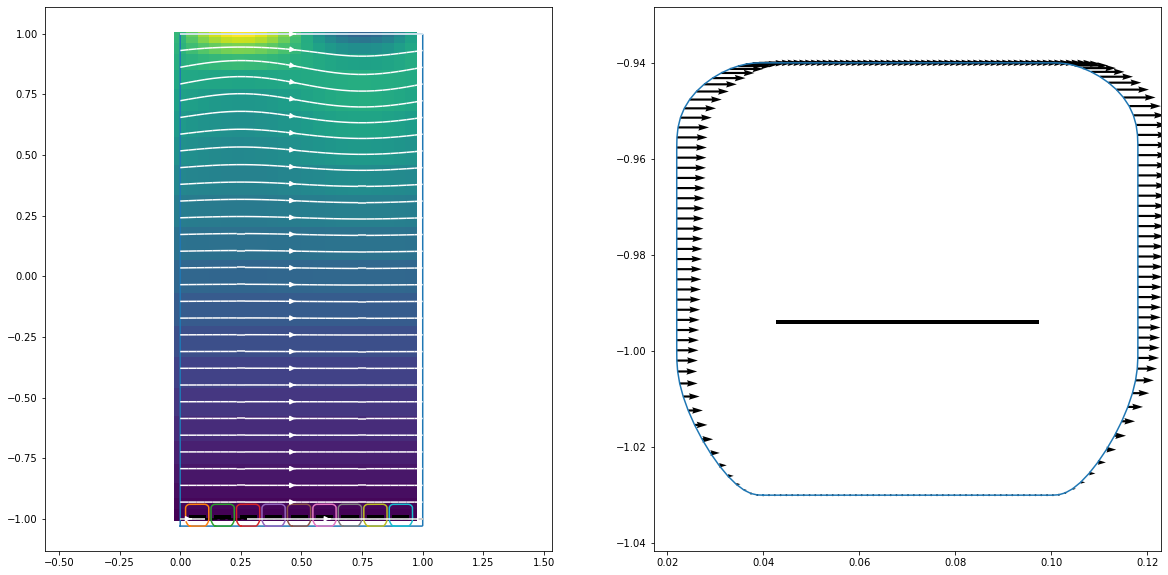

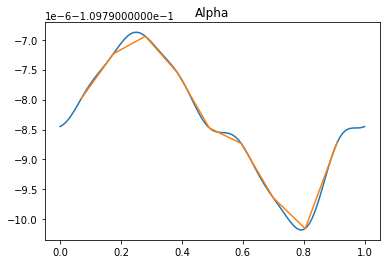

In [28]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.axis("equal")
hmm_prob.plot(plt.gca())
macro_sol.u.plot(plt.gca())
macro_sol.plot_stream(plt.gca(), color="white")

plt.subplot(122)
micros[0].plot(plt.gca())
micros[0].geom.plot_field_on_boundary(plt.gca(), micros[0].condition)
plt.axis("equal")

plt.figure()
plt.title("Alpha")
x = np.linspace(0,1,100)
a = macro.alpha(x)
xm = np.array([sol.x for sol in micro_sols])
am = np.array([sol.alpha for sol in micro_sols])
plt.plot(x, a)
plt.plot(xm, am)
#print(macro.alpha)

#plt.figure(figsize=(10,6))
#plt.title("Condition")
#t = np.linspace(0,2*np.pi, 300)
#v = micros[0].condition(t)
#plt.plot(t, np.real(v))
#plt.plot(t, np.imag(v))
#plt.xlim([1,3])

In [31]:
from util.basis_scaled import ScaleShiftedBasis, FourBasis

ScaleShiftedBasis(FourBasis.fromFunction(lambda x: np.sin(2*np.pi*x), 11), 2*np.pi, -0.5)

AttributeError: 'ScaleShiftedBasis' object has no attribute 'dim'

## Interpolate boundary conditions

Suppose we know the solution on the macroscopic domain [0,1]x[-1,1]. Reading off this boundary condition at the boundary $\Gamma$ of a micro domain would give us the solution in $\Gamma \cap [0,1]\times[-1,1]$, which is only a subset of $\Gamma$. Below is an illustration of the problem:

In [49]:
from util.basis import BasisProduct, FourBasis, ChebBasis
uBasis = BasisProduct.fromFunction(lambda x,y: (y+1+2.2*eps)**2, 41, 41, FourBasis, ChebBasis)
#uBasis.plot(plt.gca())
#uBasis.diff(0,1).plot(plt.gca())
#uBasis.diff(1, 0).plot(plt.gca())

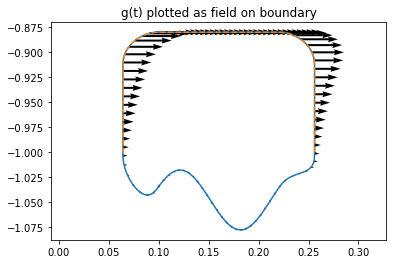

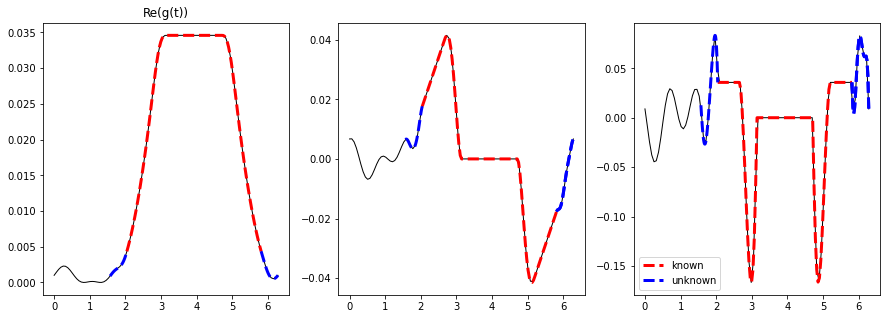

In [8]:
dxuBas = uBasis.diff(1, 0)
dyuBas = uBasis.diff(0, 1)
dxdxuBas = uBasis.diff(2, 0)
dxdyuBas = uBasis.diff(1, 1)
dydyuBas = uBasis.diff(0, 2)

def g(t):
    z = micro.geom_scaled.param[0](t)
    x, y = np.real(z), np.imag(z)
    u = np.real(uBasis(x,y))
    #h = micro.height
    #u = 0*1j + ((y + 1 + 2.2*eps)/(h + eps))**2
    return u

def dg(t):
    z = micro.geom_scaled.param[0](t)
    dz = micro.geom_scaled.param[1](t)
    
    x, y = np.real(z), np.imag(z)
    dx, dy = np.real(dz), np.imag(dz)
    
    dxg, dyg = dxuBas(x,y), dyuBas(x, y)
    u = np.real(dx * dxg + dy * dyg)
    return u

def ddg(t):
    z = micro.geom_scaled.param[0](t)
    dz = micro.geom_scaled.param[1](t)
    ddz = micro.geom_scaled.param[2](t)
    
    x, y = np.real(z), np.imag(z)
    dx, dy = np.real(dz), np.imag(dz)
    ddx, ddy = np.real(ddz), np.imag(ddz)    
    
    dxg, dyg = dxuBas(x,y), dyuBas(x, y)
    dxdxg, dxdyg, dydyg = dxdxuBas(x,y), dxdyuBas(x,y), dydyuBas(x,y)
    u = np.real(ddx * dxg + ddy * dyg + (dx**2) * dxdxg + (2*dx*dy)*dxdyg + (dy**2)*dydyg)
    return u
    

dom = micro.geom.dom
tDom = np.linspace(dom[2], dom[-2], 100)
tRight = np.linspace(dom[1], dom[2], 50)
tLeft = np.linspace(dom[-2], dom[-1], 20)
#tLeft = np.linspace(dom[-2]-5, dom[-1], 500)
#print(tLeft)

z = micro.geom_scaled.eval_param(t=tDom)
x,y = np.real(z),np.imag(z)

plt.title("g(t) plotted as field on boundary")
micro.plot(plt.gca(), relative=True)
plt.plot(x, y, '--')
micro.geom_scaled.plot_field_on_boundary(plt.gca(), g, npts=100)
plt.axis("equal")


######### PLOT BOUNDARY AND DERIVATIVES ###########################################
plt.figure(figsize=(15,5))

plt.subplot(131)
linargs={"linewidth":3}
plt.title("Re(g(t))")

t = np.linspace(0,2*np.pi,100)

plt.plot(t, np.real(g(t)), 'black', linewidth=1)
plt.plot(tDom, np.real(g(tDom)), 'r--', label="known", **linargs)
plt.plot(tRight, np.real(g(tRight)), 'b--', label="unknown", **linargs)
plt.plot(tLeft, np.real(g(tLeft)), 'b--', **linargs)

plt.subplot(132)
plt.plot(t, np.real(dg(t)), 'black', linewidth=1)
plt.plot(tDom, np.real(dg(tDom)), 'r--', label="known", **linargs)
plt.plot(tRight, np.real(dg(tRight)), 'b--', label="unknown", **linargs)
plt.plot(tLeft, np.real(dg(tLeft)), 'b--', **linargs)
plt.plot(tLeft, np.real(dg(tLeft)), 'b--', **linargs)

plt.subplot(133)
plt.plot(t, np.real(ddg(t)), 'black', linewidth=1)
plt.plot(tDom, np.real(ddg(tDom)), 'r--', label="known", **linargs)
plt.plot(tRight, np.real(ddg(tRight)), 'b--', label="unknown", **linargs)
plt.plot(tLeft, np.real(ddg(tLeft)), 'b--', **linargs)
plt.plot(tLeft, np.real(ddg(tLeft)), 'b--', **linargs)


plt.legend()    

 Total flow: 9.362545461133465e-13


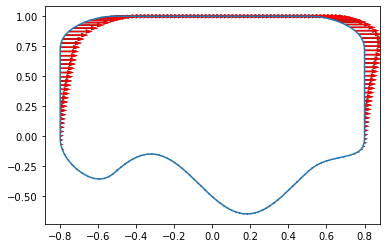

In [27]:
from numpy.polynomial.chebyshev import chebvander, chebpts1, chebgauss, chebder, chebval
from boundary_solvers.geometry import GaussLegGrid

#Projection operator is only possible with Rounded Geometry Object
g_extrap = micro.geom.project(g, dg, ddg, normdeg=2) 

flow = lambda t: np.real(g_extrap(t) * np.conjugate(micro.geom.normal(t=t)))
print(f" Total flow: {micro.geom.grid.integrate(flow)}")

micro.geom.plot(plt.gca())        
scalefun = lambda f: f
micro.geom.plot_field_on_boundary(plt.gca(), scalefun(g))
micro.geom.plot_field_on_boundary(plt.gca(), scalefun(g_extrap), color='red')

NameError: name 'g_extrap' is not defined

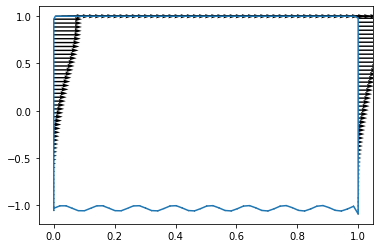

In [10]:



#dg0 = lambda t: chebval(t, chebder(c0x, m=1, scl=l0)) + 1j * chebval(t, chebder(c0y, m=1, scl=l0))
#ddg0 = lambda t: chebval(t, chebder(c0x, m=2, scl=l0)) + 1j * chebval(t, chebder(c0y, m=2, scl=l0))
#dg1 = lambda t: chebval(t, chebder(c1x, m=1, scl=l1)) + 1j * chebval(t, chebder(c1y, m=1, scl=l1))
#ddg1 = lambda t: chebval(t, chebder(c1x, m=2, scl=l1)) + 1j * chebval(t, chebder(c1y, m=2, scl=l1))
#par0 = [g0, dg0, ddg0]
#par1 = geom.param
#par2 = [g1, dg1, ddg1]
#par3 = [zerfunc,]*3
#par = []
#for i in range(3):
#    print(dom)


The purpose is now to interpolate between the known and unknown regions. Namely, suppose the known region is parameterised between $t_0$ and $t_1$, and that the unknown regions are parameterised in the intervals $[t_0^*, t_0]$ and $[t_1, t_1^*]$. Now, the goal is to find $g_0^*:[t_0^*,t_0]\to \mathbb{C}$ and $g_1^*:[t_1,t_1^*]\to \mathbb{C}$, such that $(g_1^*)^{(k)}(t_0^*)=(g_2^*)^{(k)}(t_1^*)=0$, $(g_0^*)^{(n)}(t_0)=g^{(n)}(t_0)$ and $(g_1^*)^{(n)}(t_1)=g^{(n)}(t_1)$ up to some number of derivatives $k=1,2,3,\dots, K$. Finally, we want net flow on the boundary:

\begin{equation}
    \int_{t_0^*}^{t_0} g_0^*(t)\cdot n(t)\mathrm{d}t + \int_{t_1}^{t_1^*} g_1^*(t)\cdot n(t)\mathrm{d}t = 0
\end{equation}

Together, we obtain $4K + 1$ equations to satisfy, with $4N$ unknown coefficients, depending on our choice of basis. 


In [40]:
def min_constrained(A, B, c):
    zeroM = np.zeros((B.shape[0], B.shape[0]))
    zeroV = np.zeros((A.shape[0],))
    AB = np.vstack([np.hstack([A, B.T]),
                    np.hstack([B, zeroM])])
    c0 = np.vstack([zeroV, c])
    return np.linalg.solve(AB, c0)

t0s,t0,t1,t1s = dom[1],dom[2],dom[-2],dom[-1]
z,_,_ = Geometry.interp(t0s, t0)

TypeError: interp() missing 2 required positional arguments: 'ta' and 'tb'

(-1.0, 1.0)

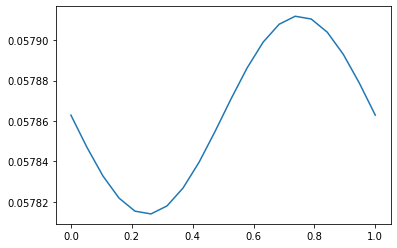

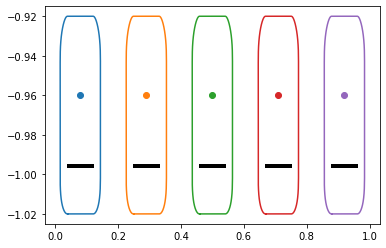

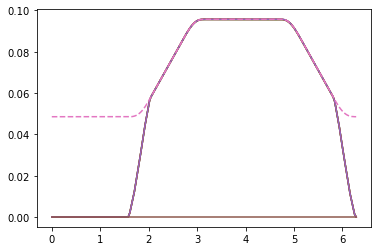

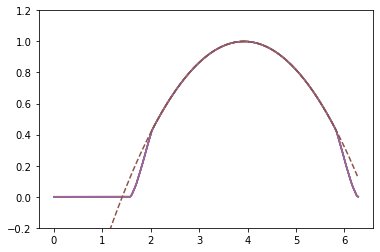

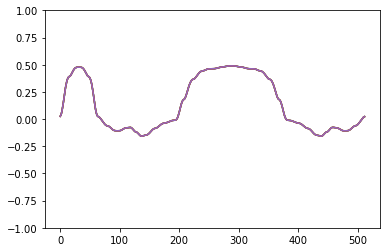

In [10]:
macro_guess = macro_solver.solve(macro)
#help(macro_guess.u)
u_x = macro_guess.u.reduce_eval(val=-1, axis=1)

t = np.linspace(0,2*np.pi, 200)
cond = []

plt.figure(3)
x = np.linspace(0, 1, 20)
#macro_guess.u.plot(plt.gca())
plt.plot(x, np.real(u_x(x)))

s = 0.8*np.pi
c = 1.25*np.pi
g = lambda t: 1 - (t-c)**2/s**2
dg = lambda t: -2*(t-c)/s**2
ddg = lambda t: -2/s**2 * np.ones_like(t)

for mic in micros:
    mic.update(macro_guess, N=13)
    z = mic.geom.eval_param(t=t)
    x,y = np.real(z), np.imag(z)
    
    
    plt.figure(1)
    mic.geom.plot(plt.gca())
    plt.scatter(np.real(mic.geom.inner_point), np.imag(mic.geom.inner_point))
    
    plt.figure(2)
    plt.plot(t, np.real(mic.condition(t)))
    
    plt.figure(4)
    g_ext = mic.geom.project(g, dg, ddg, N=13)
    plt.plot(t, np.real(g_ext(t)))
    
plt.figure(2)
plt.plot(t, 0*t)
plt.plot(t, macro_guess.u(x,y), '--')

plt.figure(4)
plt.plot(t, g(t), '--')
plt.ylim([-0.2,1.2])

plt.figure()
for s,m in zip(micro_solvers, micros):
    plt.plot(np.real(s.avg_vec))
    
    

plt.ylim([-1,1])

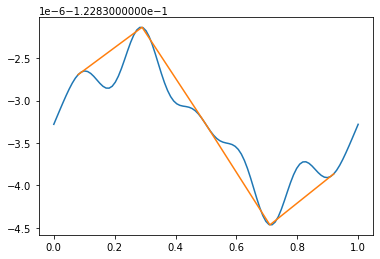

In [11]:
micro_sols = [micro_solvers[0].solve(micro) for solver, micro in zip(micro_solvers, micros)]
macro.update(micro_sols)

x = np.linspace(0,1,100)
al = macro.alpha(x)
plt.plot(x, al)
plt.plot([sol.x for sol in micro_sols], [sol.alpha for sol in micro_sols])